A global map of human gene expression
http://europepmc.org/articles/PMC2974261

Data in ArrayExpress/ 

### Imports

In [1]:
import pandas as pd
import numpy as np
import h5py

In [2]:
import pickle
import sys
sys.path.append('NormalisingData/projectX/')
from ExpressionDataset import ExpressionDataset
import mapData

In [3]:
%pylab inline
orange_color = '#d66000'
blue_color = '#005599'

Populating the interactive namespace from numpy and matplotlib


## Read E-MTAB-62 data

In [70]:
sdrf_data_fname = 'ArrayExpress/E-MTAB-62.sdrf.txt' 
fd = pd.read_csv(sdrf_data_fname, delimiter='\t')

In [ ]:
#fd.describe()
#fd['Characteristics[4 meta-groups]'].unique()

In [71]:
print np.where(fd['Characteristics[4 meta-groups]']=='normal')[0].shape
normals = fd[fd['Characteristics[4 meta-groups]']=='normal']['Source Name'].tolist()
#print normals

(1033,)


1033 entries have meta-group "normal"

In [104]:
csv_data_fname = 'ArrayExpress/hgu133a_rma_okFiles_080619_MAGETAB.csv'
# first line = sample names, tab separated, between " quotes (e.g  "1102960569.CEL"  )
# second line = to be ignored
# first column = gene names, between " quotes (e.g. "1255_g_at")

# Get sample IDs (first line of csv_data_fname)
with open(csv_data_fname, 'r') as f:
    header = f.readline() # samples 
    f.close()
    
cols = [i for (i, x) in enumerate(header.split("\t")) \
        if x.lstrip('"').rstrip('"') in normals]
print len(cols), "samples"
print cols[:10]
print [header.split("\t")[ix] for ix in cols[:10]]

1033 samples
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
['"1102960533.CEL"', '"1102960569.CEL"', '"1102960602.CEL"', '"1102960632.CEL"', '"1102960664.CEL"', '"1102960695.CEL"', '"1102960731.CEL"', '"1102960765.CEL"', '"1102960797.CEL"', '"1102960831.CEL"']


In [97]:
# Get gene names (first column of csv_data_fname)
gene_names = np.loadtxt(csv_data_fname, 
                        usecols=[0], dtype='str')
#gene_names = [x.lstrip('"').rstrip('"') for x in gene_names]
gene_names = gene_names[2:]
print len(gene_names), "genes"
print gene_names[0:10]

22283 genes
['"1007_s_at"' '"1053_at"' '"117_at"' '"121_at"' '"1255_g_at"' '"1294_at"'
 '"1316_at"' '"1320_at"' '"1405_i_at"' '"1431_at"']


In [77]:
# Get expression data itself
data = np.loadtxt(csv_data_fname, 
                  skiprows=2, delimiter='\t', usecols=cols)
data.shape

(22283, 1033)

### Map E-MTAB-62 data
This code to generate "ArrayExpress/postproc/MTAB-62.h5"

In [106]:
fcol = np.array([header.split("\t")[ix] for ix in cols])
fcol = fcol.reshape((fcol.shape[0], 1))
print fcol.shape
print data.T.shape


# Transform hgu133a_rma_okFiles_080619_MAGETAB.csv into .dat
# match the format of NormalisingData/R_playground/U133AnormalizedExpression.dat:
# first line = gene names, space-separated, between " quotes (e.g. "1255_g_at")
# first column = GSM names, between " quotes (e.g. "GSM107074.CEL.gz")

D = np.hstack((fcol, data.T))

datafile = 'ArrayExpress/postproc/hgu133a_rma_okFiles_080619_MAGETAB.dat'

np.savetxt(datafile, D, fmt='%s', comments='', delimiter=" ", 
           header=" ".join(gene_names))

(1033, 1)
(1033, 22283)


In [107]:
# Read the data as ExpressionDataset
#datafile = 'ArrayExpress/postproc/hgu133a_rma_okFiles_080619_MAGETAB.dat'
(affyIDs, patientIDs, exprMatrix, exprs) = mapData.readExpressionData(datafile)

In [108]:
### Create an ExpressionDataset object
cohort_name = 'MTAB-62'
print exprMatrix.shape
print np.array(affyIDs).shape
print len(patientIDs)
ds = ExpressionDataset(cohort_name, exprMatrix, np.array(affyIDs), np.ones(len(patientIDs)),
                      np.array(patientIDs), checkNormalization=False, checkClassLabels=False)

(1033, 22283)
(22283,)
1033


In [109]:
### Map from Affymetrix probe set ID to Entrez gene ID
#reload(mapData)
print "Map AffyIDs to Entrez gene IDs"
map_probe_ids_to_gene_ids = 'NormalisingData/projectX/HG-U133A.na32.annot.csv/' + \
    'HG-U133A.na32.annot.csv'
map_fname = 'ArrayExpress/postproc/HG-U133A.pickle'
best_map_entrez_affy = mapData.ProbeToGeneID(map_probe_ids_to_gene_ids, ds, map_fname)
best_map_affy_entrez = dict(zip(best_map_entrez_affy.values(), best_map_entrez_affy.keys()))

idx = np.argwhere(np.in1d(ds.geneLabels, best_map_affy_entrez.keys()))[:, 0]

ds_clean_probes = ds.extractGenesByIndices(('%s_clean_probes' % cohort_name), idx, 
                                          checkNormalization=False, checkClassLabels=False)

print "Replace AffyIDs with gene IDs"
for ix in range(len(ds_clean_probes.geneLabels)):
    ds_clean_probes.geneLabels[ix] = best_map_affy_entrez[ds_clean_probes.geneLabels[ix]]

print "Mean-center"
ds_clean_probes.expressionData = ds_clean_probes.expressionData - \
    ds_clean_probes.expressionData.mean(0)

### Dump clean data
res_dir = 'ArrayExpress/postproc'
ds_clean_probes = ExpressionDataset(cohort_name, ds_clean_probes.expressionData, 
                                    ds_clean_probes.geneLabels, 
                                    ds_clean_probes.patientClassLabels, 
                                    ds_clean_probes.patientLabels, 
                                    checkNormalization=False, checkClassLabels=False)
pickle.dump(ds_clean_probes, open('%s/%s_data.pickle' % (res_dir, cohort_name), 'wb'))

Map AffyIDs to Entrez gene IDs
Columns in mapping file:
['"Probe Set ID', 'GeneChip Array', 'Species Scientific Name', 'Annotation Date', 'Sequence Type', 'Sequence Source', 'Transcript ID(Array Design)', 'Target Description', 'Representative Public ID', 'Archival UniGene Cluster', 'UniGene ID', 'Genome Version', 'Alignments', 'Gene Title', 'Gene Symbol', 'Chromosomal Location', 'Unigene Cluster Type', 'Ensembl', 'Entrez Gene', 'SwissProt', 'EC', 'OMIM', 'RefSeq Protein ID', 'RefSeq Transcript ID', 'FlyBase', 'AGI', 'WormBase', 'MGI Name', 'RGD Name', 'SGD accession number', 'Gene Ontology Biological Process', 'Gene Ontology Cellular Component', 'Gene Ontology Molecular Function', 'Pathway', 'InterPro', 'Trans Membrane', 'QTL', 'Annotation Description', 'Annotation Transcript Cluster', 'Transcript Assignments', 'Annotation Notes"\n']
Replace AffyIDs with gene IDs
Mean-center


In [110]:
### Convert pickle data into hdf5 format
from ConvertPickleData import EmitDataset
res_dir = 'ArrayExpress/postproc'

data_clean = pickle.load(open('%s/%s_data.pickle' % (res_dir, cohort_name)))

hdf5_fname = '%s/%s.h5' % (res_dir, cohort_name)
hdf5_f = h5py.File(hdf5_fname, 'w')
EmitDataset(data_clean, None, hdf5_f)
hdf5_f.close()  

Adding dataset: MTAB-62
['Entrez_780' 'Entrez_5982' 'Entrez_7318' ..., 'Entrez_11033' 'Entrez_4034'
 'Entrez_54869']


This resulted in generating the data file holding the E-MTAB-62 data: "ArrayExpress/postproc/MTAB-62.h5"

## Find interesting gene pairs in ACES_RFS data

In [4]:
# Get ACES data
h5ds = h5py.File("ACES/experiments/data/U133A_combat.h5")
X = np.array(h5ds['U133A_combat_RFS']['ExpressionData'])
y = np.array(h5ds['U133A_combat_RFS']['PatientClassLabels'])
aces_gene_names =  np.array(h5ds['U133A_combat_RFS']['GeneLabels'])
h5ds.close()
print X.shape
print aces_gene_names[20]

(1616, 12750)
Entrez_6207


In [5]:
# Positivie and negative entries
i_pos = np.where(y)[0]
i_neg = np.where(y != True)[0]
print len(i_pos), len(i_neg)

455 1161


In [6]:
# Normalize the data
x_mean = np.mean(X, axis=0)
x_stdv = np.std(X, axis=0, ddof=1)
Xnorm = X - x_mean
Xnorm /= x_stdv

In [7]:
# Create correlation matrix
W = np.corrcoef(np.transpose(Xnorm))

In [9]:
# Take absolute values
W = np.abs(W)

In [27]:
Wthresholded = np.where(W > 0.8, W, 0)
Wthresholded[np.diag_indices(X.shape[1])] = 0
np.where(Wthresholded)

(array([  119,   180,   286, ..., 12626, 12626, 12708]),
 array([ 2543,  9775,  3152, ...,  7023, 12371,  8732]))

In [34]:
print W[286, 3152], Wpos[286, 3152]

0.88254116387 0.892177718874


W[17, 36] = 0.65584707445795032

The distributions of positive and negative are similar

## Regression line for ACES-RFS

In [46]:
gene_a = 286
gene_b = 3152
n, p = X.shape
reg_w = np.linalg.lstsq(np.array([ Xnorm[:, gene_a], np.ones(n) ]).T, Xnorm[:, gene_b])[0]
[w0, w1] = reg_w

In [65]:
dmax = 0
imax = -1
for ix in range(n):
    x0 = Xnorm[ix, gene_a]
    y0 = Xnorm[ix, gene_b]
    distance = np.abs(w0*x0 - y0 + w1) / np.sqrt(w0**2+1)
    #print ix, distance
    if distance > dmax:
        dmax = distance
        imax = ix
print imax, dmax

1377 2.45878013087


-1.92319820154 -0.296220977048 1.58208705853 -0.261427205847


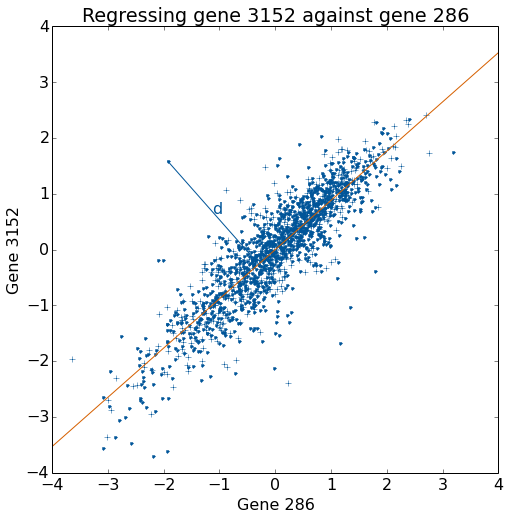

In [67]:
rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(Xnorm[i_pos, gene_a], Xnorm[i_pos, gene_b], marker="+", ls='', color=blue_color)
plot(Xnorm[i_neg, gene_a], Xnorm[i_neg, gene_b], marker=".", ls='', color=blue_color)
plot(np.arange(-4, 4.1, 0.1),  w0*np.arange(-4, 4.1, 0.1) + w1, ls='-', color=orange_color)
xlim(-4, 4)
ylim(-4, 4)
xlabel('Gene %s' % gene_a)
ylabel('Gene %s' % gene_b)
title('Regressing gene %s against gene %s' % (gene_b, gene_a))

# single out one point
sample_idx = 1377
x0 = Xnorm[sample_idx, gene_a]
y0 = Xnorm[sample_idx, gene_b]
#plot(x0, y0, marker="*", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
print x0, a, y0, b
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('regline_example.pdf', bbox='tight_layout')

## Look at gene vs. gene plots in ACES-RFS and E-MTAB-62 data

In [111]:
# Get reference data
f = h5py.File("ArrayExpress/postproc/MTAB-62.h5")
X_ref = f['MTAB-62']['ExpressionData']
print X_ref.shape
ref_gene_names =  f['MTAB-62']['GeneLabels']

(1033, 12750)


In [112]:
# Reorder reference data so that genes map those in ACES data
# reordered_genes[0] = index of aces_gene_names[0] in ref_gene_names
ref_gene_names = list(ref_gene_names)
ref_gene_names_dict = dict([(a, ix) for ix, a in enumerate(ref_gene_names)]) # name:idx
#print ref_gene_names_dict
reordered_genes = [ref_gene_names_dict[a] for a in aces_gene_names]
#print ref_gene_names[reordered_genes[20]]
#X_ref = X_ref[:, reordered_genes]
X_ref_reordered = np.array(X_ref)
for ix in range(X_ref.shape[1]):
    X_ref_reordered[:, ix] = X_ref[:, reordered_genes[ix]]

In [116]:
# Normalize the data
x_mean = np.mean(X_ref_reordered, axis=0)
x_stdv = np.std(X_ref_reordered, axis=0, ddof=1)

Xnorm = X - x_mean
Xnorm /= x_stdv

X_ref_norm = X_ref_reordered - x_mean
X_ref_norm /= x_stdv

In [117]:
gene_a = 286
gene_b = 3152
n, p = X_ref_norm.shape
reg_w = np.linalg.lstsq(np.array([ X_ref_norm[:, gene_a], np.ones(n) ]).T, 
                        X_ref_norm[:, gene_b])[0]
[w0, w1] = reg_w

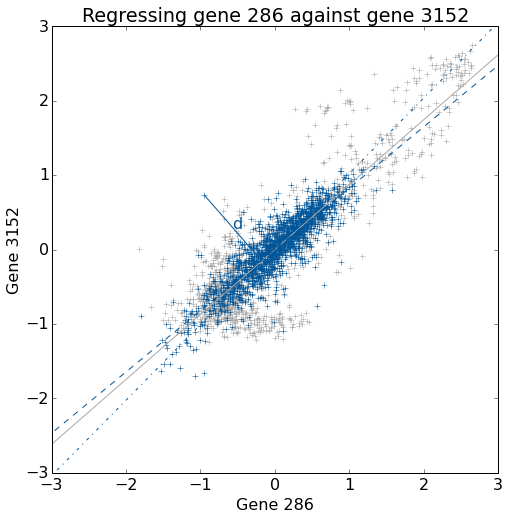

In [123]:
rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(X_ref_norm[:, gene_a], X_ref_norm[:, gene_b], marker="+", ls='', color='darkgrey')
plot(Xnorm[:, gene_a], Xnorm[:, gene_b], marker="+", ls='', color=blue_color)

plot(np.arange(-4, 4.1, 0.1),  w0*np.arange(-4, 4.1, 0.1) + w1, ls='-', color='darkgrey')


#reg_w_aces = np.linalg.lstsq(np.array([ Xnorm[:, gene_a], np.ones(Xnorm.shape[0]) ]).T, 
#                            Xnorm[:, gene_b])[0]
#plot(np.arange(-4, 4.1, 0.1), reg_w_aces[0]*np.arange(-4, 4.1, 0.1) + reg_w_aces[1], 
#    ls='--', color=blue_color)

#reg_w_aces = np.linalg.lstsq(np.array([ X[:, gene_a], np.ones(X.shape[0]) ]).T, 
#                            X[:, gene_b])[0]
#plot(np.arange(-4, 4.1, 0.1), reg_w_aces[0]*np.arange(-4, 4.1, 0.1) + reg_w_aces[1], 
#    ls='-.', color=blue_color)


xlim(-3, 3)
ylim(-3, 3)
xlabel('Gene %d' % gene_a)
ylabel('Gene %d' % gene_b)
title('Regressing gene %d against gene %d' % (gene_a, gene_b))

# single out one point
sample_idx = 1377
x0 = Xnorm[sample_idx, gene_a]
y0 = Xnorm[sample_idx, gene_b]
#plot(x0, y0, marker="o", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('ArrayExpress/postproc/regline_example.pdf', bbox='tight_layout')

## Comparing network structures based on ACES data and reference data

In [ ]:
f = h5py.File("ACES/experiments/data/U133A_combat.h5")
sampleLabels = np.array(f['U133A_combat_RFS']['PatientClassLabels'])
Xrfs = np.array(f['U133A_combat_RFS']['ExpressionData'])
f.close()
numGenes = Xrfs.shape[1]

# Restrict the data to the negative samples
Xpos = Xrfs[np.where(sampleLabels)[0], :]
        
# Restrict the data to the negative samples
Xneg = Xrfs[np.where(np.logical_not(sampleLabels))[0], :]
        
# Compute Pearson's correlation, gene by gene
globalNetwork = np.corrcoef(np.transpose(Xrfs))

In [ ]:
# Threshold the network
threshold = 0.8
#globalNetwork = np.where(np.logical_or(np.logical_or(globalNetwork > threshold,
#                                       np.corrcoef(np.transpose(Xneg)) > threshold),
#                                       np.corrcoef(np.transpose(Xpos)) > threshold),
#                                      globalNetwork, 0)
globalNetwork = np.where(globalNetwork > threshold, globalNetwork, 0)
# Only keep the upper triangular matrix (it's symmetric)
globalNetwork[np.tril_indices(numGenes)] = 0
        
print np.count_nonzero(globalNetwork), 'edges'

# List non-zero indices (i.e edges)
Waces = np.nonzero(globalNetwork)
Waces = np.array([Waces[0], Waces[1]], dtype='int').transpose()

In [ ]:
Wref = np.loadtxt('outputs/U133A_combat_RFS/reglref_edges.gz', dtype='int')

In [ ]:
#Waces = np.loadtxt('outputs/U133A_combat_RFS/reglref_edges_based-on-data.gz', dtype='int')

In [ ]:
print Wref[0, :]
print Waces[0, :]
Wref_set = set(["%d_%d" % (x[0], x[1]) for x in Wref.tolist()])
print '0_23' in Wref_set, '0_2351' in Wref_set
counter = 0
for x in Waces.tolist():
    xstr = "%d_%d" % (x[0], x[1])
    if xstr not in Wref_set:
        counter += 1
print counter, "edges from Waces not in Wref"
print len(Waces.tolist())

In [ ]:
f = h5py.File("ArrayExpress/postproc/MTAB-62.h5")
Xref = np.array(f['MTAB-62']['ExpressionData'])
f.close()
numGenes = Xref.shape[1]

In [ ]:
# Compute Pearson's correlation, gene by gene
globalNetwork = np.corrcoef(np.transpose(Xref))

In [ ]:
for threshold in [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    print "threshold:", threshold
    globalNetwork = np.where(globalNetwork > threshold, globalNetwork, 0)
    # Only keep the upper triangular matrix (it's symmetric)
    globalNetwork[np.tril_indices(numGenes)] = 0
        
    print np.count_nonzero(globalNetwork), 'edges'

    # Compute connectivities
    connectivities = np.round(np.sum(globalNetwork + globalNetwork.T, axis=1))

    nnodes = np.shape(np.nonzero(connectivities))[1]
    print "nodes:", nnodes
    print "density:", (2*np.sum(connectivities)/(nnodes * (nnodes-1)))
# List non-zero indices (i.e edges)
#Waces = np.nonzero(globalNetwork)
#Waces = np.array([Waces[0], Waces[1]], dtype='int').transpose()

In [ ]:
# Compute connectivities
connectivities = np.round(np.sum(globalNetwork + globalNetwork.T, axis=1))

nnodes = np.shape(np.nonzero(connectivities))[1]
print "nodes:", nnodes
print "density:", (2*np.sum(connectivities)/(nnodes * (nnodes-1)))

In [ ]:
# Compute mean network connectivity
ave_conn = np.mean(connectivities)
print "Average connectivity:", ave_conn

# Compute log10(connectivites)
k_values = np.unique(connectivities)
if k_values[0] == 0:
    k_values = k_values[1:]
l_k_values = np.log10(k_values)
        
# Compute log10(freq(connectivities))
connectivities_bin_count = np.bincount(np.round(connectivities).astype(int))[1:]
l_freq_k = np.log10(connectivities_bin_count[np.where(connectivities_bin_count > 0)[0]])

# Fit regression line
k_w, residuals = np.linalg.lstsq(np.array([ l_k_values, np.ones(len(k_values)) ]).T,
                                 l_freq_k)[:2]
slope = k_w[0]
print "Slope:", slope

r2 = 1 - residuals[0] / (l_freq_k.size * l_freq_k.var())
print "R2:", r2

In [ ]:
plt.plot([0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9], 
        [0.81, 0.82, 0.85, 0.87, 0.87, 0.87, 0.82, 0.81])
plt.axis([0.54, 0.91, 0.7, 1])

## What follows is junk

## Check whether normalization can be done with respect to the reference data.

In [ ]:
x_mean = np.mean(X_ref_reordered, axis=0)
print "mean:", x_mean
x_stdv = np.std(X_ref_reordered, axis=0, ddof=1)
print "stdv:", x_stdv
X_ref_normalized = np.array(X_ref_reordered)
X_ref_normalized -= x_mean
X_ref_normalized /= x_stdv

In [ ]:
X_normalized = np.array(X)
X_normalized -= x_mean
X_normalized /= x_stdv

In [ ]:
n, p = X_ref_normalized.shape
print n, p
reg_w = np.linalg.lstsq(np.array([X_ref_normalized[:, 1], np.ones(n) ]).T, X_ref_normalized[:, 811])[0]

In [ ]:
[w0, w1] = reg_w

rcParams.update({'font.size': 16})
figure(figsize=(8, 8))
plot(X_ref_normalized[:, 1], X_ref_normalized[:, 811], marker="+", ls='', color='darkgrey')
plot(X_normalized[:, 1], X_normalized[:, 811], marker="x", ls='', color=blue_color)

plot(np.arange(-2, 2.1, 0.1),  w0*np.arange(-2, 2.1, 0.1) + w1, ls='-', color=orange_color)
xlim(-2, 2)
ylim(-2, 2)
xlabel('Gene A')
ylabel('Gene B')
#title('Regressing Gene B against Gene A')

# single out one point
sample_idx = 473
x0 = X_normalized[sample_idx, 1]
y0 = X_normalized[sample_idx, 811]
plot(x0, y0, marker="o", ls='', color=blue_color)
a = (w0 * (y0 - w1) + x0)/(1 + w0**2)
b = (w1 + w0 * (x0 + w0 * y0))/(1 + w0**2)
plot([x0, a], [y0, b], ls='-', color=blue_color)
text(0.5*(x0+a), 0.5*(y0+b), 'd', color=blue_color)

savefig('ArrayExpress/postproc/regline_normalized_example.pdf', bbox='tight_layout')

In [ ]:
### STEP 1 (do we need this?): Compute correlations between samples
#import pickle
#import calculatePC
#import ensure_dir
#print "Computing correlation between samples (takes time)"
#res_dir = 'results/heatmaps'
#ensure_dir(res_dir)
#corr, corr_hist = calculatePC(ds.expressionData)
#pickle.dump(corr, open('%s/%s_corr_matrix.pickle' % (res_dir, cohort_name), 'wb'))

#corr_mean, corr_hist_mean = calculatePC(ds_mean.expressionData)
#pickle.dump(corr_mean, open('%s/%s_corr_matrix_mean.pickle' % (res_dir, cohort_name), 'wb'))


### STEP 2: Detect and remove similar samples (possible duplicates).
sim_thresh = 0.9 # similarity threshold: remove samples that show high correlation
data = pickle.load(open("%s/%s_data.pickle")) # combatData.pickle

# TODO IDENTIFY SIMILAR PAIRS    
print "Cohort has %d similar pairs" % len(sim_pairs)
    
remove_samples = removeSamplesRandomElimination(sim_pairs)   
print "Removing %d samples" % len(remove_samples)

# find indices of the removed samples in the merged dataset
try:
    remove_samples_idx = np.argwhere(np.in1d(data.patientLabels, remove_samples))[:, 0]
except:
    remove_samples_idx = np.argwhere(np.setmember1d(data.patientLabels, remove_samples))[:, 0]
    
patient_idx = range(len(data.patientLabels))
ds_clean_samples = data.extractPatientsByIndices(("ALL_%s_cleanSamples" % cohort_name),
                                                 list(set(patient_idx).difference(remove_samples_idx)), 
                                                 False, False)    

print "Map AffyIDs to Entrez gene IDs"
mapProbeIdsToGeneIds = 'NormalisingData/projectX/HG-U133A.na32.annot.csv/HG-U133A.na32.annot.csv'
best_map_entrez_affy = ProbeToGeneID(mapProbeIdsToGeneIds, ds_clean)
best_map_affy_entrez = dict(zip(best_map_entrez_affy.values(), best_map_entrez_affy.keys()))
try:
    idx = np.argwhere(np.in1ds(ds_clean_samples.geneLabels, best_map_affy_entrez.keys()))[:, 0]
except:
    idx = np.argwhere(np.setmember1d(ds_clean_samples.geneLabels, best_map_affy_entrez.keys()))[:, 0]
data_clean = ds_clean_samples.extractGenesByIndices(('%s_clean_probes' % cohort_name), idx, 
                                          checkNormalization=False, checkClassLabels=False)

print "Replace AffyIDs with gene IDs"
for ix in range(len(data_clean.geneLabels)):
    data_clean.geneLabels[ix] = best_map_affy_entrez[data_clean.geneLabels[ix]]

print "Mean-center"
data_clean.expressionData = data_clean.expressionData - data_clean.expressionData.mean(0)

# save to pickle
pickle.dump(data_clean, open('%s/%s_all_data.pickle' % (res_dir, cohort_name), 'wb')    

In [ ]:
import pylab
from matplotlib.backends.backend_pdf import PdfPages
def compute_pca(matrix, plot_title, plot_fname):
    """Compute PCA of a matrix.
    
    Parameters
    ----------
    matrix: np.array
        covariance matrix or data matrix (variables x observations).
    
    plot_title: string
        Title of plot.
        
    plot_fname: filename
        Path to file where to save PC plot (as pdf).
    
    Returns
    -------
    fpc: np.array 
        first principal component
        
    spc: np.array 
        second principal component
    
    Created files
    -------------
    plot_fname: Plot the data (first PC against second PC)
    
    """
    if matrix.shape[0] == matrix.shape[1]:
        # covariance matrix
        w, v = np.linalg.eigh(matrix)
        # first PC
        fpc = v[:, len(w)-1]
        # second PC
        spc = v[:, len(w)-2]
    else:
        # data matrix
        data = matrix.copy()
        pcomps, trans, w = pylab.prepca(data.T)
        fpc = pcomps[0, ]
        spc = pcomps[1, ]
    #print "First PC", fpc
    #print "Second PC", spc
        
    # Plot first PC against second PC
    print "Plot first PC against second PC in %s" % plot_fname
    pdf = PdfPages(plot_fname)
    fig = plt.figure(figsize=(8, 8))
    plt.plot(fpc, spc, ".", color='darkgrey')
    
    plt.xlabel("First PC", fontsize=16)
    plt.ylabel("Second PC", fontsize=16)
    plt.title(plot_title, fontsize=16)
    xmin = min(fpc)
    xmax = max(fpc)
    ymin = min(spc)
    ymax = max(spc)
    plt.axis([xmin-50, xmax+100, ymin-20, ymax+20])
    pdf.savefig()
    pdf.close()
    plt.clf()
    
    return fpc, spc